In [1]:
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.stats import norm
from glob import glob
from matplotlib.ticker import ScalarFormatter

In [2]:
# CONFIGURATION

M      = 25  # Number of angles in plane projection. Total parameter space is M^2.
MW_REF = 3.6 * 45 # Effective radius multiplier of MW in kpc.

plt.rcParams.update({
    'font.size': 14,
    'legend.fontsize': 'large',
    'axes.labelsize': 'large',
    'axes.titlesize':'large',
    'xtick.labelsize':'large',
    'ytick.labelsize':'large'})

# Analytic functions

In [3]:
def plane_sample(n):
    P = []
    a, b = np.random.uniform(0, 2*np.pi, 2)
    while (len(P) < n):
        x, y = np.random.uniform(-1, 1, 2)
        z = -(x*np.cos(a)*np.cos(b) + y*np.sin(a)*np.cos(b)) / np.sin(b)
        if x**2 + y**2 + z**2 < 1:
            P.append((x, y, z))
    return np.array(P)

def spherical_sample(n, frac=1):
    P=[]
    while (len(P) < n):
        x, y, z = np.random.uniform(-1, 1, 3)
        if x**2 + y**2 + z**2/frac**2 < 1:
            P.append((x,y,z))
    return np.array(P)

@njit
def to_spherical_coord(P):
    x, y, z = P[:,0], P[:,1], P[:,2]
    r = (x**2+y**2+z**2)**.5
    theta = np.arccos(z / r)
    phi = np.sign(y) * np.arccos(x / (x**2+y**2)**.5)
    theta = np.where(phi < 0, np.pi - theta, theta)
    phi = np.where(phi < 0, np.pi + phi, phi)
    return theta, phi

@njit
def project_(P):
    x = y = z = 0
    L = []
    for i in range(len(P)):
        for j in range(len(P)):
            if i < j:
                p = np.cross(P[i], P[j])
                x, y, z = p[0], p[1], p[2]
                r = (x**2+y**2+z**2)**.5
                theta = np.arccos(z / r)
                phi = np.sign(y) * np.arccos(x / (x**2+y**2)**.5)                
                if phi < 0:
                    theta = np.pi - theta
                    phi = np.pi + phi
                L.append((theta, phi,))
    return np.array(L)

def project(P, m=M):
    L = project_(P)
    return np.histogram2d(
        L[:,0], L[:,1],
        bins=m,
        range=[[0, np.pi],[0, np.pi]])[0] 


def eps_q(p, theta, sigma, eps):
    return theta + sigma*np.where(
        p<(1+eps)/2,
        (1+eps)*norm.ppf(p/(1+eps)),
        (1-eps)*norm.ppf((p-eps)/(1-eps)))

def eps_fit(q_16, q_50, q_84):
    Q = np.array([.16,.5,.84])
    V = np.array([q_16, q_50, q_84])
    res = minimize(
        lambda a: np.sqrt(((eps_q(Q, *a) - V)**2).sum()),
        [q_50, np.abs(q_50-q_16), 0],
        bounds=(
            (q_16, q_84),
            (0, q_84-q_16),
            (-1, 1)),
        method="Nelder-Mead")
    assert res.success
    return res.x

def rv(x):
    def f(y):
        params = eps_fit(*y)
        return lambda p: eps_q(p, *params)
    return [f(x[i]) for i in range(len(x))]

def resample(fx, fy, fz):
    n = len(fx)
    def samp():
        x = [f(p) for f,p in zip(fx, np.random.uniform(0,1,n))]
        y = [f(p) for f,p in zip(fy, np.random.uniform(0,1,n))]
        z = [f(p) for f,p in zip(fz, np.random.uniform(0,1,n))]
        return np.vstack([x,y,z]).T
    return samp

@njit
def gini(x):
    x = x.flatten()
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def inter():
    p = np.cross(pos_repl(), vel_repl())
    return project(p)

# Random spherical percentile metric distribution

In [4]:
Q = []

for i in range(2,300):
    x = [gini(project(spherical_sample(i))) for _ in range(1000)]
    q = np.quantile(x, np.arange(0,101)/100.)
    Q.append(q)

Q = np.vstack(Q)

def metric_q(q, n):
    assert n >= 2
    assert 0 <= q <= 100
    return Q[n-2, q]

def metric_v(v, n):
    assert n >= 2
    q = Q[n-2, :].flatten()
    return (np.sum(v > q)-1) / 100.

# Prepare data

In [5]:
D    = pd.read_csv("cartesian.csv")
cond = (D[["x_mid", "y_mid", "z_mid"]].values**2).sum(axis=1)**.5 < MW_REF
D    = D[cond]
m = len(D)

p_lo = D[["x-","y-","z-"]].values
p_50 = D[["x_mid","y_mid","z_mid"]].values
p_hi = D[["x+","y+","z+"]].values
p_16 = p_50 - p_lo
p_84 = p_hi + p_50
P = lambda i: np.vstack([p_16[:,i], p_50[:,i], p_84[:,i]]).T

v_lo = D[["vx-","vy-","vz-"]].values
v_50 = D[["vx_mid","vy_mid","vz_mid"]].values
v_hi = D[["vx+","vy+","vz+"]].values
v_16 = v_50 - v_lo
v_84 = v_hi + v_50
V = lambda i: np.vstack([v_16[:,i], v_50[:,i], v_84[:,i]]).T

px, py, pz = P(0), P(1), P(2)
vx, vy, vz = V(0), V(1), V(2)

print("Total satellites", len(D))

Total satellites 39


# Fit distribution

In [6]:
pos_repl = resample(rv(px), rv(py), rv(pz))
vel_repl = resample(rv(vx), rv(vy), rv(vz))

# Establish that random plane spaces can be clearly distinguished

Random sig. 0.07
Position sig. 1.0
Velocity sig. 0.286


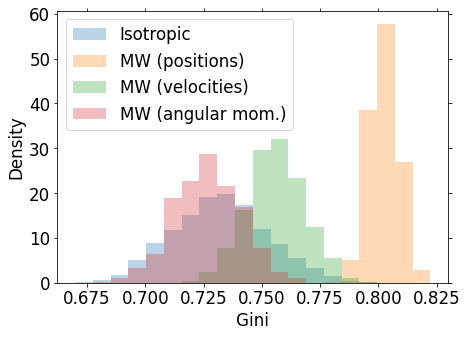

In [7]:
x_rnd = [gini(project(spherical_sample(39))) for _ in range(1000)]
x_pos = [gini(project(pos_repl())) for _ in range(1000)]
x_vel = [gini(project(vel_repl())) for _ in range(1000)]
x_int = [gini(inter()) for _ in range(1000)]

print("Random sig.", np.sum(x_rnd > metric_q(95, 39)) / len(x_rnd))
print("Position sig.", np.sum(x_pos > metric_q(95, 39)) / len(x_pos))
print("Velocity sig.", np.sum(x_vel > metric_q(95, 39)) / len(x_vel))

bins=np.histogram(np.concatenate([x_rnd, x_pos, x_vel, x_int]), bins=20)[1]
plt.figure(figsize=(7,5))
plt.hist(x_rnd, bins, density=True, alpha=.3, label = "Isotropic")
plt.hist(x_pos, bins, density=True, alpha=.3, label = "MW (positions)")
plt.hist(x_vel, bins, density=True, alpha=.3, label = "MW (velocities)")
plt.hist(x_int, bins, density=True, alpha=.3, label = "MW (angular mom.)")
plt.legend()
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
#plt.tight_layout()
plt.xlabel("Gini")
plt.ylabel("Density")

## Spherical distribution

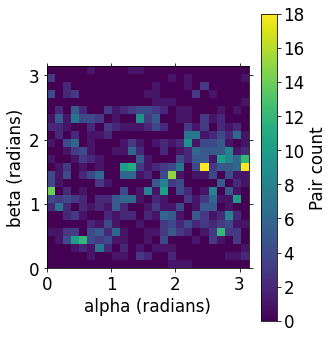

In [10]:
p = project(spherical_sample(45))
plt.figure(figsize=(5,5))
plt.imshow(p, extent=[0, np.pi, 0, np.pi])
plt.xlabel("alpha (radians)")
plt.ylabel("beta (radians)")
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
c = plt.colorbar()
c.set_label("Pair count")
plt.tight_layout()

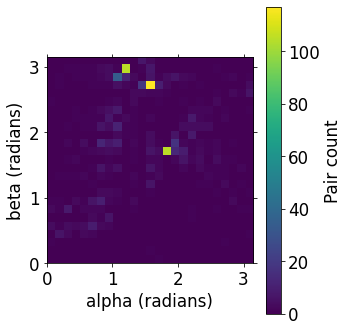

In [9]:
p = np.concatenate(
    [plane_sample(15), plane_sample(15), plane_sample(15)])
p = project(p)
plt.figure(figsize=(5,5))
plt.imshow(p, extent=[0, np.pi, 0, np.pi])
plt.xlabel("alpha (radians)")
plt.ylabel("beta (radians)")
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
c = plt.colorbar()
c.set_label("Pair count")
plt.tight_layout()

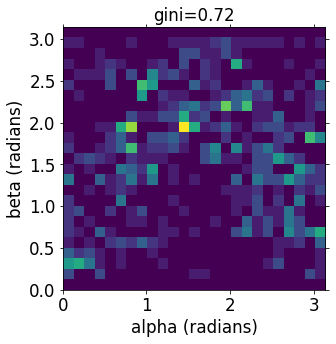

In [10]:
p = project(spherical_sample(39))
plt.figure(figsize=(5,5))
plt.imshow(p,extent=[0, np.pi, 0, np.pi])
plt.xlabel("alpha (radians)")
plt.ylabel("beta (radians)")
plt.title("gini=%.2f" % gini(p))
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
plt.tight_layout()

## Milkyway position vectors

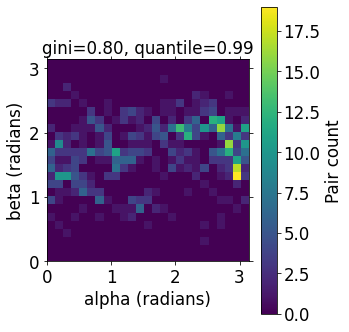

In [11]:
p = project(p_50)
plt.figure(figsize=(5,5))
plt.imshow(p,extent=[0, np.pi, 0, np.pi])
plt.xlabel("alpha (radians)")
plt.ylabel("beta (radians)")
plt.title("gini=%.2f, quantile=%.2f" % (gini(p), metric_v(gini(p), 39)))
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
c = plt.colorbar()
c.set_label("Pair count")
plt.tight_layout()

## Milkyway velocity vectors

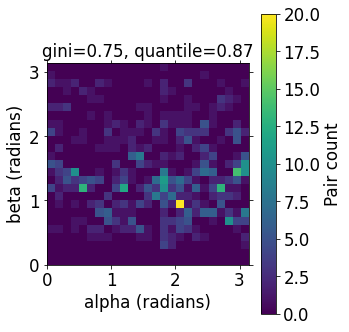

In [12]:
p = project(v_50)
plt.figure(figsize=(5,5))
plt.imshow(p,extent=[0, np.pi, 0, np.pi])
plt.xlabel("alpha (radians)")
plt.ylabel("beta (radians)")
plt.title("gini=%.2f, quantile=%.2f" % (gini(p), metric_v(gini(p), 39)))
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
c = plt.colorbar()
c.set_label("Pair count")
plt.tight_layout()

## Milkyway angular momenta

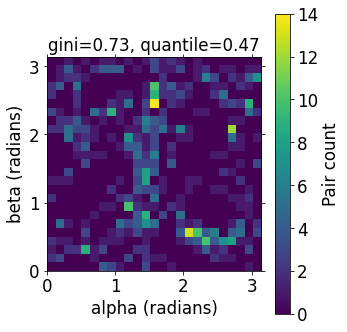

In [13]:
p = project(np.cross(p_50, v_50))
plt.figure(figsize=(5,5))
plt.imshow(p,extent=[0, np.pi, 0, np.pi])
plt.xlabel("alpha (radians)")
plt.ylabel("beta (radians)")
plt.title("gini=%.2f, quantile=%.2f" % (gini(p), metric_v(gini(p), 39)))
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
c = plt.colorbar()
c.set_label("Pair count")
plt.tight_layout()

# New Horizon Simulation

# Utility functions

In [14]:
import re

def get_timesteps():
    l = []
    for fn in glob("data/galaxy_props_*AdaoptaHOP.csv"):
        x = re.search("([0-9]+)", fn)
        l.append(int(x.groups(1)[0]))
    return np.flip(np.sort(l))

def get_gal_props(tid):
    prop_cols = [
        "id", "level", "mass", "x", "y", "z", "vx", "vy", "vz",
        "radius", "r_from_host", "r_from_nearest_substructure", 
        "mass_ratio_host", "t_95", "t_alive"]
    return pd.read_csv(
        "data/galaxy_props_%d_AdaoptaHOP.csv" % tid,
        sep='\s+',
        header=None,
        comment="#",
        names=prop_cols)

def get_pro_ids(tid1,tid2):
    f = np.loadtxt('data/tree_ids_NH_AdaptaHOP_%i.txt' % tid1)
    tree_ids = np.int32(f[1:,-1])
    tree_snapshots = np.int32(f[0,:])
    tree_native_ids = np.int32(f[1:,:])
    new_ids = tree_native_ids[:,tree_snapshots==tid2].flatten().tolist()
    ids = tree_ids.tolist()
    return dict(zip(new_ids, ids))

def get_pro_ids2(snapshot,new_snapshot,gal_id):
    f = np.loadtxt('data/tree_ids_NH_AdaptaHOP_%i.txt' % snapshot)
    tree_ids = np.int32(f[1:,-1])
    tree_snapshots = np.int32(f[0,:])
    tree_native_ids = np.int32(f[1:,:])
    new_id = tree_native_ids[tree_ids == gal_id,tree_snapshots==new_snapshot]
    return new_id

def get_redshift():
    tbl = np.loadtxt("data/snapshot_key.txt")
    k = tbl[:,0].astype(int)
    return dict(zip(k, tbl[:,1]))

def get_cosmic_time():
    tbl = np.loadtxt("data/snapshot_key.txt")
    k = tbl[:,0].astype(int)
    return dict(zip(k, tbl[:,2]))

mergers = pd.read_csv(
    "data/merger_catalogue_949_max_mass_NH_AdaptaHOP.txt",
    delim_whitespace=True)
mergers = mergers[mergers["main"] == 1]
mergers = mergers[mergers.mass_ratio > 0.1]

def get_mergers(id):
    return mergers[mergers.final_hst_id == id]


# Analytical functions

In [63]:
def horizon_systems(G):
    ref, vels = G[["x", "y", "z"]].values, G[["vx","vy","vz"]].values
    idxs =  np.arange(0, len(ref))

    cond_host = G.mass > 1e10
    cond_sat  = (G.mass < 1e10) & (G.mass > 1e5) # lower and upper mass cuts.
    r         = G.radius[cond_host].values.reshape(-1,1)
    sats      = distance_matrix(ref[cond_host], ref[cond_sat])
    sats      = sats / r
    sats      = (sats > 3) & (sats < 45)

    for i in np.argwhere(sats.sum(axis=1) > 0).flatten():
        norm_pos = ref[cond_sat][sats[i]] - ref[cond_host][i]
        norm_vel = vels[cond_sat][sats[i]] - vels[cond_host][i]
        
        yield (
            G[cond_host].iloc[i],
            G[cond_sat][sats[i]].reset_index(drop=True),
            norm_pos, norm_vel)

# Longitudinal analysis of final hosts

In [64]:
ts_init = 949
l = []
redshift = get_redshift()
cosmic = get_cosmic_time()
for ts in get_timesteps():
    if ts > ts_init:
        continue
    G = get_gal_props(ts)
    ids = get_pro_ids(ts_init, ts)
    for g, m, P, V in horizon_systems(G):
        if len(P) < 2 or not ids.get(int(g.id)):
            continue
        l.append({
            "ts": ts,
            "redshift": redshift[ts],
            "cosmic": cosmic[ts],
            "gid": ids[int(g.id)],
            "rnd": metric_q(100, len(m)),
            "sats": len(m),
            "mass": g.mass,
            "p_gini": gini(project(P)),
            "v_gini": gini(project(V))
        })

l = pd.DataFrame(l)

# Longitudinal positional analysis all hosts

[0.75       0.85714286 0.91428571 0.946875   1.        ]


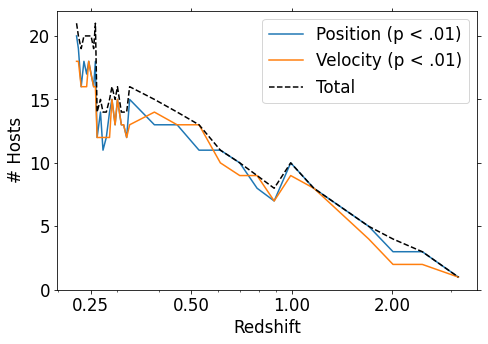

In [65]:
o = l[(l.sats > 30) & (l.mass >= 10**10)]
gt_100 = o.groupby("redshift").apply(lambda x: np.sum(x.p_gini > x.rnd))
vt_100 = o.groupby("redshift").apply(lambda x: np.sum(x.v_gini > x.rnd))
total = o.groupby("redshift").sats.count().values

plt.figure(figsize=(7,5))
plt.plot(gt_100.index.values, gt_100.values, label="Position (p < .01)")
plt.plot(gt_100.index.values, vt_100.values, label="Velocity (p < .01)")
plt.plot(gt_100.index.values, total, color="black", linestyle="--", label="Total")
plt.xscale("log")
plt.xticks([0.25,0.5,1,2])
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.xlabel("Redshift")
plt.ylabel("# Hosts")
plt.legend()
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
plt.tight_layout()
plt.savefig("writing/images/long-all.png")
print(np.quantile(gt_100/total, [0,.25,.5,.75,1]))

# Longitudinal analysis final hosts only.

In [ ]:
orig_ids = l.gid[(l.ts==ts_init) & (l.sats > 30) & (l.mass >= 10**10)]
orig = l[l.gid.isin(orig_ids)]
top_4 = orig.groupby("gid").ts.count().sort_values(ascending=False).head(4).index
orig = l[l.gid.isin(top_4)]
fig, axs = plt.subplots(4, figsize=(7,9))

for i, gid in enumerate(orig.gid.unique()):
    o = orig[orig.gid == gid]
    axs[i].set_ylim([0, 1.1])
    axs[i].set_xlim([orig.redshift.min(), orig.redshift.max()])
    axs[i].tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=False)
    axs[i].plot(o.redshift.values, o.p_gini.values, label="Host (position)", color="green")
    axs[i].plot(o.redshift.values, o.v_gini.values, label="Host (velocity)", color="brown")
    axs[i].plot(o.redshift.values, o.rnd.values, linestyle="--", color="black", label="Isotropic")
    axs[i].set_xscale("log")
    axs[i].set_xticks([0.25,0.5,1,2])
    axs[i].get_xaxis().set_major_formatter(ScalarFormatter())
    m = get_mergers(gid)
    print(gid, np.sum(m.redshift < 3), len(m))
    m = m[m.redshift <= o.redshift.max()]
    for a in m.redshift:
        axs[i].axvline(a, linestyle="--", color="r", alpha=.5)

plt.legend(fontsize=12)
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
plt.ylabel("Gini coefficient")
plt.xlabel("Redshift")
plt.tight_layout()

[0.25       0.75       0.8125     0.86666667 1.        ]


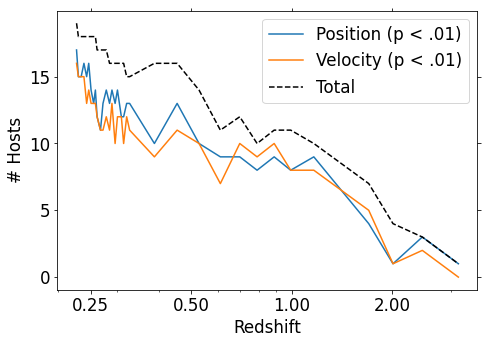

In [27]:
o = l[l.gid.isin(orig_ids)]
gt_100 = o.groupby("redshift").apply(lambda x: np.sum(x.p_gini > x.rnd))
vt_100 = o.groupby("redshift").apply(lambda x: np.sum(x.v_gini > x.rnd))
total = o.groupby("redshift").sats.count().values

plt.figure(figsize=(7,5))
plt.plot(gt_100.index.values, gt_100.values, label="Position (p < .01)")
plt.plot(gt_100.index.values, vt_100.values, label="Velocity (p < .01)")
plt.plot(gt_100.index.values, total, linestyle="--", color="black", label="Total")
plt.xlabel("Redshift")
plt.xscale("log")
plt.xticks([0.25,0.5,1,2])
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.ylabel("# Hosts")
plt.legend()
plt.tick_params(top=True, right=True, labeltop=False, bottom=True, labelbottom=True)
plt.tight_layout()